In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import selfies as sf
import counterstone as cs
import warnings

warnings.filterwarnings('ignore')
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
#soldata = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/3407241?format=original&gbrecs=true')
# had to rehost because dataverse isn't reliable
soldata = pd.read_csv('https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv')
features_start_at = list(soldata.columns).index('MolWt')
np.random.seed(0)

/scratch/gwellawa/.conda/htf2/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
soldata.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


In [3]:
# filter out long smiles
smask = [len(s) <= 96 for s in soldata.SMILES] 
print(f'Removed {soldata.shape[0] - sum(smask)} long SMILES strings')
filtered_soldata = soldata[smask]
# convert SMILES into SELFIES
smiles = list(filtered_soldata.SMILES)
selfies = [sf.encoder(x) for x in smiles]
# not all smiles are converted to selfies; filter again
smask2 = [s is not None for s in selfies] 
filtered_soldata = filtered_soldata[smask2]
# filtered selfies
selfies = list(filter(None, [sf.encoder(x) for x in smiles]))

# make tokenizer with 128 size vocab and 
# have it examine all text in dataset
vocab_size = 128
tokenizer = tf.keras.preprocessing.text.Tokenizer(vocab_size, filters='', char_level=True)
tokenizer.fit_on_texts(selfies)

Removed 285 long SMILES strings


In [4]:
# now get padded sequences
seqs = tokenizer.texts_to_sequences(selfies)
#seqs = tokenizer.texts_to_sequences(filtered_soldata.SMILES)
print(f'Number of molecules: {len(seqs)}')
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, padding='post')

# Now build dataset
data = tf.data.Dataset.from_tensor_slices((padded_seqs, filtered_soldata.Solubility))
# now split into val, test, train and batch
N = len(data)  
split = int(0.1 * N)
test_data = data.take(split).batch(16)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(16), nontest.skip(split).shuffle(1000).batch(16)

Number of molecules: 9657


In [5]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated as padding mask
model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=16, mask_zero=True))

# RNN layer
model.add(tf.keras.layers.GRU(32))
# a dense hidden layer
model.add(tf.keras.layers.Dense(32, activation='relu'))
# regression, so no activation
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          2048      
_________________________________________________________________
gru (GRU)                    (None, 32)                4800      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 7,937
Trainable params: 7,937
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(tf.optimizers.Adam(1e-2), loss='mean_squared_error')
result = model.fit(train_data, validation_data=val_data, epochs=25, verbose=0)

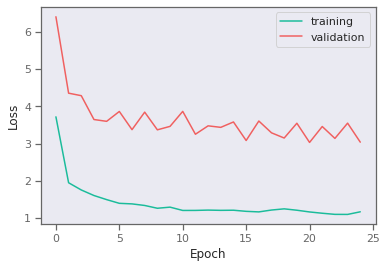

In [7]:
plt.plot(result.history['loss'], label='training')
plt.plot(result.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## CF explanation:

In the following example let's say we would like our molecules to return a solubility value of -3.5. Here we use `counterstone` algorithm to create counter factual explanations. In other words, we would like to see what are the minimal mutations that could to be done to our input structure to get our desired solubility.

In [16]:
def predictor_function(smile_list,selfies):
     #let's say we want the solubility to be this value
    example_seqs = tokenizer.texts_to_sequences(smile_list)
    padded_exseq = tf.keras.preprocessing.sequence.pad_sequences(example_seqs, padding='post')
    labels = model.predict(padded_exseq)
    target_sol = np.ones(len(labels.flatten()))*(-3.5)

    return abs(target_sol-labels.flatten())<0.8 

In [40]:
cf_exp = cs.explain('CCOCOCCl', predictor_function)

NUMBER OF UNIQUE SMILES 857
[5 7 9 4 6 1 1 0 8 3 3 2 0 1]


In [41]:
cf_exp

[Explanation(smiles='CCOCOCCl', selfies='', similarity=1.0, position=array([0, 0]), is_counter=True, is_base=True),
 Explanation(smiles='CCOCO[S-]CCl', selfies=None, similarity=0.5185185185185185, position=array([-0.48294493, -0.13463932]), is_counter=True, is_base=False)]

In [30]:
cs.plot_explanation(exps)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

<Figure size 432x288 with 0 Axes>